In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bayesian_pdes
import sympy as sp
import scipy.stats
%matplotlib inline
%load_ext line_profiler
import time
import Cython
%load_ext Cython

In [2]:
ni = 18
nb = 9

In [3]:
x_1,x_2,y_1,y_2 = sp.symbols('x_1 x_2 y_1 y_2')
length_scale = 0.05
k = sp.exp(-((x_1-y_1)**2+(x_2-y_2)**2) / (2.*length_scale**2))
A = lambda f: sp.diff(f, x_1, x_1) + sp.diff(f, x_2, x_2)
Abar = lambda f: sp.diff(f, y_1, y_1) + sp.diff(f, y_2, y_2)
B = lambda f: f
Bbar = lambda f: f
symbols = [[x_1, x_2], [y_1, y_2]]

# interior observations: sin(x)*sin(y)
x_interior, y_interior = np.mgrid[0.1:0.9:ni*1j, 0.1:0.9:ni*1j]
interior = np.c_[x_interior.ravel(), y_interior.ravel()]
exterior = np.r_[
    np.c_[np.linspace(0.1,0.9,nb), np.zeros(nb)], 
    np.c_[np.linspace(0.1,0.9,nb), np.ones(nb)],
    np.c_[np.zeros(nb), np.linspace(0.1,0.9,nb)],
    np.c_[np.ones(nb), np.linspace(0.1,0.9,nb)]
]

interior_obs = np.sin(2*np.pi*interior[:,0]) + np.sin(2*np.pi*interior[:,1])
exterior_obs = np.r_[
    np.zeros(nb*2),
    np.zeros(nb*2)
]

print interior.shape, interior_obs.shape
print exterior.shape, exterior_obs.shape
#%lprun -f bayesian_pdes.collocation.calc_LLbar posterior = bayesian_pdes.collocate([A, B], [Abar, Bbar], k, symbols, [(interior, interior_obs), (exterior, exterior_obs)])

(324, 2) (324,)
(36, 2) (36,)


In [4]:
1./0.05

20.0

In [5]:
sp.simplify(A(k))

((400.0*x_1 - 400.0*y_1)**2 + (400.0*x_2 - 400.0*y_2)**2 - 800.0)*exp(-200.0*(x_1 - y_1)**2 - 200.0*(x_2 - y_2)**2)

In [86]:
# set up the Allen-Cahn system
d = sp.Symbol('delta')
#d = 0.04
n_pts = 11

def A_1(delta):
    return lambda f: -delta*(sp.diff(f, x_1, x_1) + sp.diff(f, x_2, x_2)) - 1./delta * f

def A_1_bar(delta):
    return lambda f: -delta*(sp.diff(f, y_1, y_1) + sp.diff(f, y_2, y_2)) - 1./delta * f

Identity = lambda f: f
B = Identity

# for now collocate on a basic grid (this is not efficient)
x, y = np.mgrid[0:1:n_pts*1j, 0:1:n_pts*1j]
x = x.ravel(); y = y.ravel()

on_bdy = (x == 0.) | (x == 1.) | (y == 0.) | (y == 1.)

collocate_interior = np.c_[x[~on_bdy], y[~on_bdy]]

collocate_boundary = np.c_[x[on_bdy], y[on_bdy]]

# define what the RHS of the system looks like
def rhs(locations):
    return np.zeros(location.shape[0])

# and on the boundary...
def boundary_rhs(locations):
    ret = np.empty(locations.shape[0])
    # impose condition on the y boundary
    y_bdy = (locations[:,1] == 1) | (locations[:,1] == 0)
    ret[y_bdy] = -1
    # impose condition on the x boundary
    x_bdy = (locations[:,0] == 1) | (locations[:,0] == 0)
    ret[x_bdy] = 1
    
    if np.any(~(x_bdy | y_bdy)):
        missing = locations[~(x_bdy | y_bdy), :]
        raise Exception("Some boundary observations don't appear to be on the boundary: {}".format(missing))
    return ret

boundary_obs = boundary_rhs(collocate_boundary)

In [87]:
def cube_root(arr):
    arr = np.asarray(arr)
    ret = np.empty_like(arr)
    ret[arr >= 0] = arr[arr > 0]**(1./3)
    ret[arr < 0] = - np.abs(arr[arr < 0])**(1./3)
    return ret

# Calculation of Importance Distn

In [88]:
from deflation.deflation import ForwardProblem
from deflation.petscsnessolver import PetscSnesSolver
import dolfin
from dolfin import dx
import math
import logging
logging.getLogger('FFC').setLevel(logging.WARNING)

In [89]:
# for ipython notebook
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.tri as tri

def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

def plot(obj):
    plt.gca().set_aspect('equal')
    if isinstance(obj, dolfin.Function):
        mesh = obj.function_space().mesh()
        if (mesh.geometry().dim() != 2):
            raise(AttributeError)
        if obj.vector().size() == mesh.num_cells():
            C = obj.vector().array()
            plt.tripcolor(mesh2triang(mesh), C)
        else:
            C = obj.compute_vertex_values(mesh)
            plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    elif isinstance(obj, dolfin.Mesh):
        if (obj.geometry().dim() != 2):
            raise(AttributeError)
        plt.triplot(mesh2triang(obj), color='k')


In [90]:
import sys
args = [sys.argv[0]] + """
                       --petsc.snes_max_it 200
                       --petsc.snes_monitor
                       --petsc.snes_converged_reason
                       --petsc.snes_stol 0.0
                       --petsc.snes_rtol 0.0
                       --petsc.snes_type newtonls
                       --petsc.snes_linesearch_type basic

                       --petsc.ksp_type gmres
                       --petsc.ksp_rtol 1.0e-12
                       --petsc.ksp_atol 1.0e-12

                       --petsc.inner_pc_type lu
                       """.split()
dolfin.parameters.parse(argv=args)

In [146]:
def retry(fun, tries, success_condition=None, debug=True):
    for i in xrange(tries):
        try:
            res = fun()
        except Exception as ex:
            if debug: 
                print 'Attempt {} failed with exception {}'.format(i, ex)
            continue
        
        if success_condition is not None and success_condition(res):
            return res
        else:
            return res
        if debug:
            print 'Attempt {} failed'.format(i)
    raise Exception('Failed to find solution in {} tries'.format(tries))
    
meshes = {}
def find_solutions(delta, mesh_points, initial_guesses=None, max_solutions=3, stop_on_divergence=False, plot_solutions=False):
    # reuse mesh if we can
    if mesh_points in meshes:
        mesh = meshes[mesh_points]
    else:
        mesh = dolfin.UnitSquareMesh(mesh_points, mesh_points)
        size = dolfin.MPI.size(dolfin.mpi_comm_world())
        if size > 1:
            nrefine = math.log(size, 4)
            if int(nrefine) != nrefine:
                print "Need to have processors a power of 4, as each refinement multiplies work by 4"
                assert False

            for i in range(int(nrefine) + 3):
                mesh = dolfin.refine(mesh, redistribute=False)
        meshes[mesh_points] = mesh

    V = dolfin.FunctionSpace(mesh, "CG", 1)
    Vdim = V.dim()
    #if dolfin.MPI.rank(dolfin.mpi_comm_world()) == 0:
    #    print "Degrees of freedom: ", Vdim
    #    print "Degrees of freedom per core: ", Vdim/float(size)

    delta = dolfin.Constant(delta)

    u = dolfin.Function(V)

    v = dolfin.TestFunction(V)
    F = delta * dolfin.inner(dolfin.grad(v), dolfin.grad(u))*dx + 1.0/delta * dolfin.inner(v, u**3 - u)*dx

    bcs = [dolfin.DirichletBC(V, +1.0, "x[0] == 0.0 || x[0] == 1"),
           dolfin.DirichletBC(V, -1.0, "x[1] == 0.0 || x[1] == 1")]

    power = 1
    shift = 0.1
    problem = ForwardProblem(F, V, u, bcs, power=power, shift=shift)
    solver = PetscSnesSolver()

    roots = []
    natol = 1.0e-8

    for i in xrange(max_solutions):
        if initial_guesses is not None:
            u.assign(initial_guesses[i])
        dolfin.PETScOptions.set("snes_atol", natol)
        try:
            solver.solve(problem, u.vector())
        except Exception as ex:
            if stop_on_divergence:
                break
            else:
                raise
            
        roots.append(dolfin.Function(u, name="Solution"))

        if plot_solutions:
            plt.figure()
            plot(roots[-1])
            plt.colorbar()
            plt.show()

        u.assign(dolfin.Constant(0))
        problem.deflate(roots[-1])
        if shift > 0:
            natol *= shift
    return roots

In [92]:
def compute_latent(points, delta, solutions):
    # it is most convenient to compute the latent variables as the cube of the values at the points (i.e. at A_2),
    # since this means we don't have to fuss about with gradients.
    res = np.empty((points.shape[0], len(solutions)))
    for i in range(len(solutions)):
        res[:,i] = np.vectorize(solutions[i])(points[:,0], points[:,1])
    return -res**3 / delta

In [93]:
counts = {}
for delta in np.linspace(0.03, 0.2):
    solutions = find_solutions(delta, 100, max_solutions=5, stop_on_divergence=True, plot_solutions=False)
    print 'Delta={}, {} solutions'.format(delta, len(solutions))
    counts[delta] = len(solutions)

KeyboardInterrupt: 

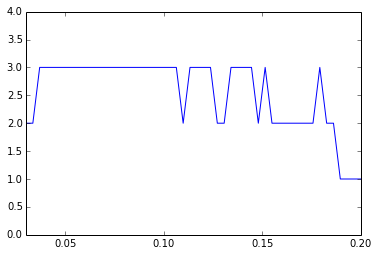

In [85]:
deltas, values = np.array(counts.keys()), np.array(counts.values())
order = np.argsort(deltas)
plt.plot(deltas[order], values[order])
plt.ylim(0,4);
plt.xlim(deltas.min(), deltas.max());

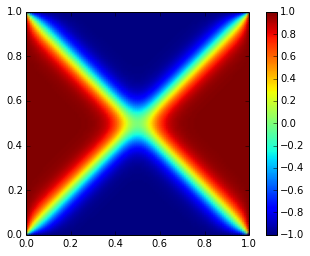

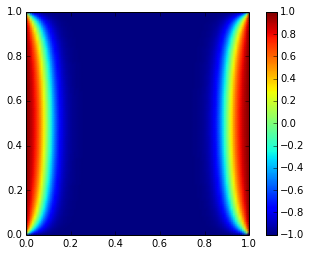

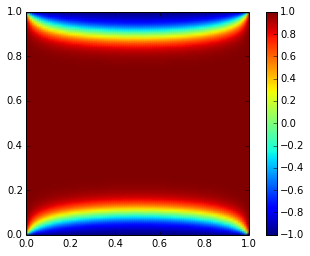

In [94]:
delta = 0.04
true_solutions = find_solutions(delta, 100, max_solutions=3, stop_on_divergence=False, plot_solutions=True)

In [95]:
true_solution_values = np.vectorize(true_solutions[0])(collocate_interior[:,0], collocate_interior[:,1])
true_obs = (collocate_interior, true_solution_values)

A sensible range looks like $\delta \in [0.035, 0.1]$. It looks (however) as though while it becomes difficult to find solutions after this point, the three-solution regime is not broken until closer to $\delta=0.2$

In [96]:
z = compute_latent(collocate_interior, delta, true_solutions)

In [97]:
def collocate_latent(z, delta, ops, ops_bar, operator_cache=None):
    obs = [
        (collocate_interior, z),
        (collocate_interior, cube_root(-delta*z)),
        (collocate_boundary, boundary_obs)
    ]
    
    posterior = bayesian_pdes.collocate(ops, ops_bar, k, symbols, obs, operator_cache)
    
    return posterior

In [98]:
def plot_mean(locations, mu):
    size = int(np.sqrt(locations.shape[0]))
    shape = (size, size)
    plt.contourf(locations[:,0].reshape(shape), locations[:,1].reshape(shape), mu.reshape(shape))

# Sampling from the LV distribution

In [99]:
def sample_latent(solutions, delta, test_points, n_samples=5, rho=1.0, debug=False):
    z = compute_latent(collocate_interior, delta, solutions)
    
    # generate the operator cache since we will be evaluating multiple times
    
    ops, ops_bar, op_cache = ops_allen_cahn(delta)
    
    # now we sample from a mixture of solutions
    # let's first pretend that we know the solution and sample from it
    
    for i in xrange(z.shape[1]):
        plt.figure(figsize=(5*n_samples,5))
        this_z = z[:,i]
        for j in xrange(n_samples):
            dist = scipy.stats.multivariate_normal(this_z, rho)
            z_star = dist.rvs()
            
            if debug:
                start = time.time()
            posterior = collocate_latent(z_star, delta, ops, ops_bar, op_cache)
            
            if debug:
                print 'Generation of posterior took {}'.format(time.time() - start)
                start = time.time()
            mu, Sigma = posterior(test_points)
            if debug:
                print 'Evaluation of posterior took {}'.format(time.time() - start)
                start = time.time()
            plt.subplot(1,n_samples, j+1)

            plot_mean(test_points, mu)
            plt.title('p={}'.format(dist.pdf(z_star)))
            plt.colorbar()

In [106]:
test_x, test_y = np.mgrid[0:1:21j, 0:1:21j]
test = np.c_[test_x.ravel(), test_y.ravel()]

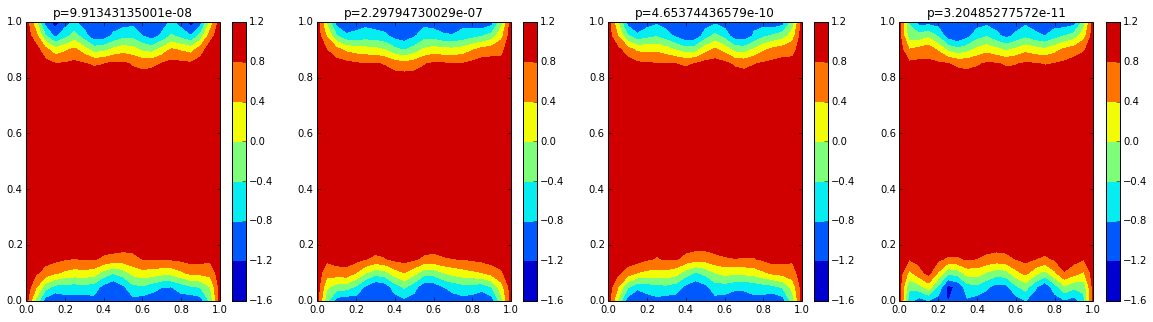

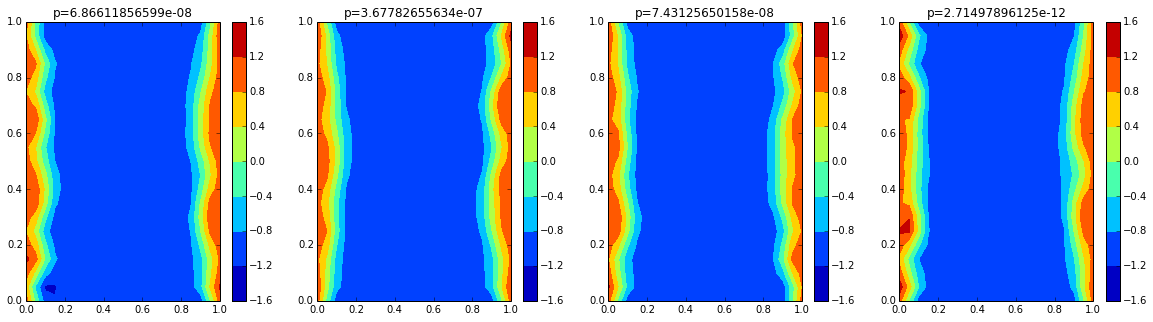

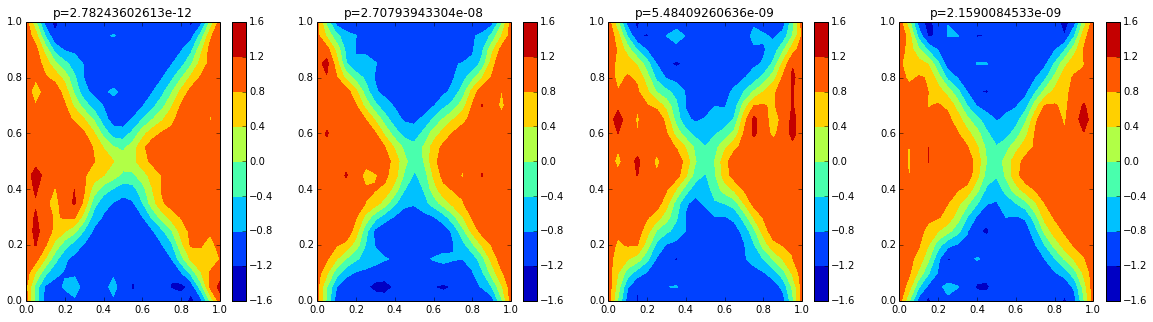

In [177]:
solutions = find_solutions(delta, 25, max_solutions=3)
sample_latent(solutions, delta, test, n_samples=4, rho=0.1)

# Calculation of PN Probability

## Fast C version of operators

In [108]:
%%cython
cimport numpy as np
import numpy as np
cdef extern from "math.h":
    double sqrt(double x)
    double exp(double x)
    
cdef double length_scale = 0.1
cdef double inverse_ls_sq = 1./(length_scale**2)
cdef double inverse_ls_sq_2 = 1./(length_scale**4)

cdef double sq_dist(np.ndarray[np.float_t, ndim=1] x_1, np.ndarray[np.float_t, ndim=1] x_2):
    cdef double ret = (x_1[0] - x_2[0])**2
    for i in xrange(1, len(x_1)):
        ret += (x_1[i] - x_2[i])**2
    return ret

cdef double k_eval(double sd):
    return exp(-0.5*sd*inverse_ls_sq)

cdef double poisson_k(double sd, double k, int n):
    return inverse_ls_sq * (inverse_ls_sq*sd - n) * k

def poisson_k_2(double sd, double k, double pk, int n):
    return inverse_ls_sq_2 * (2*n*k + sd*pk -4*inverse_ls_sq*sd*k) - n*inverse_ls_sq*pk
    #return (sd*inverse_ls_sq_2 - n*inverse_ls_sq)*pk + 2*n*k*inverse_ls_sq_2
    
def k_cython(np.ndarray[np.float_t, ndim=2] x_1, np.ndarray[np.float_t, ndim=2] x_2):
    cdef int i,j
    cdef np.ndarray[np.float_t, ndim=2] ret = np.empty((x_1.shape[0], x_2.shape[0]))
    for i in xrange(x_1.shape[0]):
        for j in xrange(x_2.shape[0]):
            sd = sq_dist(x_1[i,:], x_2[j,:])
            ret[i,j] = k_eval(sd)
    return ret

def Ak_cython(np.ndarray[np.float_t, ndim=2] x_1, np.ndarray[np.float_t, ndim=2] x_2, double delta):
    cdef np.ndarray[np.float_t, ndim=2] ret = np.empty((x_1.shape[0], x_2.shape[0]))
    cdef int i,j
    cdef double delta_inv = 1./delta
    
    cdef double sd, k, pk
    cdef int n = x_1.shape[1]
    for i in xrange(x_1.shape[0]):
        for j in xrange(x_2.shape[0]):
            sd = sq_dist(x_1[i,:], x_2[j,:])
            k = k_eval(sd)
            pk = poisson_k(sd, k, n)
            
            ret[i,j] = -delta * pk - delta_inv * k
    return ret

def AAk_cython(np.ndarray[np.float_t, ndim=2] x_1, np.ndarray[np.float_t, ndim=2] x_2, double delta):
    cdef np.ndarray[np.float_t, ndim=2] ret = np.empty((x_1.shape[0], x_2.shape[0]))
    cdef int i,j
    cdef double delta2 = delta*delta
    cdef double delta_inv_2 = 1./delta2
    cdef int n = x_1.shape[1]
    
    cdef double sd, k, pk, pk2
    for i in xrange(x_1.shape[0]):
        for j in xrange(x_2.shape[0]):
            sd = sq_dist(x_1[i,:], x_2[j,:])
            k = k_eval(sd)
            pk = poisson_k(sd, k, n)
            pk2 = poisson_k_2(sd, k, pk, n)
            
            ret[j,i] = delta2*pk2 + 2*pk + delta_inv_2*k
    return ret

In [109]:
# build the dict
def ops_allen_cahn(delta):
    # we need every 0,1 and 2 combination of A, Abar and I
    A_op = 'A'
    Abar_op = 'A_bar'
    Ident_op = 'Identity'
    
    Ak_apply = lambda x_1, x_2: Ak_cython(x_1, x_2, delta)
    AAk_apply = lambda x_1, x_2: AAk_cython(x_1, x_2, delta)
    
    ret = {}
    ret[tuple()] = k_cython
    
    ret[A_op] = Ak_apply
    ret[Abar_op] = Ak_apply
    ret[Ident_op] = k_cython
    
    # operators themselves
    ret[(A_op, Ident_op)] = Ak_apply
    ret[(Ident_op, A_op)] = Ak_apply
    ret[(Abar_op, Ident_op)] = Ak_apply
    ret[(Ident_op, Abar_op)] = Ak_apply
    ret[(A_op, Abar_op)] = AAk_apply
    ret[(Abar_op, A_op)] = AAk_apply
    ret[(Ident_op, Ident_op)] = k_cython
    
    return (A_op, Ident_op, Ident_op), (Abar_op, Ident_op, Ident_op), ret

In [110]:
ops, ops_bar, ops_cache = ops_allen_cahn(0.04)

In [168]:
def log_p_pn(true_obs, posterior, sigma, debug=False, plot=False):
    """
    true_obs: Tuple of observation locations and observation values for the true solution u
    delta: The current value of the parameter delta
    z: The current value of the latent variable z
    sigma: Allowed observation error in the Gaussian likelihood.
    returns: The PN probability p(y | delta)
    """
    true_locations, y = true_obs
    mu, Sigma = posterior(true_locations)
    
    error_mat = np.eye(mu.shape[0])*sigma**2
    Sigma_plus_error = Sigma + error_mat
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        plot_mean(true_locations, mu)
        plt.colorbar()
        
        plt.subplot(122)
        plt.colorbar(plt.imshow(Sigma + error_mat, interpolation=None))
        plt.show()
        
    #Sigma_plus_error_inv = np.linalg.inv(Sigma_plus_error)
    
    #exponent = -0.5 * (y - mu).T.dot(Sigma_plus_error_inv).dot(y - mu)
    #assert type(exponent) is np.float64, "Exponent is of the wrong type, expected a float but was {}.".format(type(exponent))
    #fractional = np.linalg.det(2*np.pi*Sigma_plus_error)
    
    if debug:
        print 'True | Mean'
        print np.c_[y, mu]
        print 'Average abs. error: {}'.format(np.mean(np.abs(y-mu)))
    
    return scipy.stats.multivariate_normal.logpdf(y, mean=mu, cov=Sigma_plus_error, allow_singular=False)
    #return 1./np.sqrt(fractional) * np.exp(exponent)

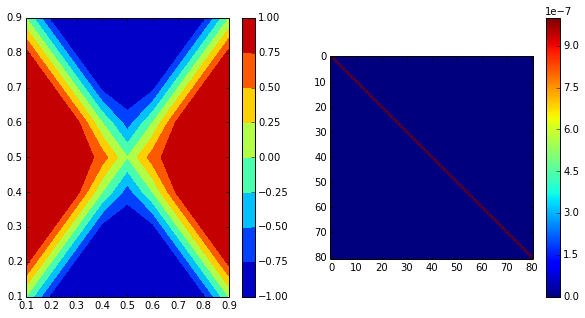

True | Mean
[[ -3.80173956e-05  -9.15080793e-03]
 [  8.50677144e-01   8.36512803e-01]
 [  9.86841250e-01   9.88207749e-01]
 [  9.98909608e-01   9.99011271e-01]
 [  9.99827345e-01   9.99932567e-01]
 [  9.98960572e-01   9.99849098e-01]
 [  9.87130466e-01   9.86841086e-01]
 [  8.50667120e-01   8.35433327e-01]
 [  3.84972458e-07   7.20762423e-05]
 [ -8.50694529e-01  -8.40939522e-01]
 [ -2.63721263e-05  -6.27810332e-03]
 [  8.48563308e-01   8.36122804e-01]
 [  9.86569240e-01   9.88185723e-01]
 [  9.97783978e-01   9.98806113e-01]
 [  9.86846913e-01   9.93694670e-01]
 [  8.48498677e-01   8.33766589e-01]
 [  1.05859143e-06   2.40917623e-04]
 [ -8.50666717e-01  -8.35315693e-01]
 [ -9.86842629e-01  -9.88511068e-01]
 [ -8.48575325e-01  -8.39234172e-01]
 [ -1.64848740e-05  -3.85940618e-03]
 [  8.45858666e-01   8.35201612e-01]
 [  9.70928404e-01   9.71190486e-01]
 [  8.45716021e-01   8.30966043e-01]
 [  1.75218184e-06   3.30888480e-04]
 [ -8.48497880e-01  -8.33547565e-01]
 [ -9.87130411e-01  -9.868

-3762.3161666301057

In [172]:
delta = 0.04
solutions = find_solutions(delta, 25, max_solutions=3, stop_on_divergence=False, plot_solutions=False)
z = compute_latent(collocate_interior, delta, solutions)

ops, ops_bar, ops_cache = ops_allen_cahn(delta)

posterior = collocate_latent(z[:,2], delta, ops, ops_bar, operator_cache=ops_cache)
log_p_pn(true_obs, posterior, 1e-3, debug=True, plot=True)

In [114]:
def log_p_pn_estimate(true_obs, delta, solutions, sigma, rho, n_samples, debug=False):
    # generate all of the operators and the cache here so we don't have to compute inside the loop (which is slow)
    ops = [A_1(delta), Identity, B]
    ops_bar = [A_1_bar(delta), Identity, B]
    
    #op_cache = bayesian_pdes.generate_op_cache(ops, ops_bar, k, symbols)
    ops, ops_bar, op_cache = ops_allen_cahn(delta)
    
    z = compute_latent(collocate_interior, delta, solutions)
    w = 1. / len(solutions) * np.ones(len(solutions))  # equal weighting for each solution
    w_cumulative = w.cumsum()
    estimates = np.empty(n_samples)
    # nb this is just an uninformative prior for now...
    log_prior = lambda z: 0.
    for i in xrange(n_samples):
        mixture_ix = np.argwhere(np.random.uniform() < w_cumulative).min()
        if debug:
            print 'Iteration {}, mixture {}'.format(i, mixture_ix)
        dist = scipy.stats.multivariate_normal(z[:, mixture_ix], rho)
        z_star = dist.rvs()
        log_r = np.log(w[mixture_ix]) + dist.logpdf(z_star)
        
        posterior = collocate_latent(z_star, delta, ops, ops_bar, op_cache)
        log_pn_proba = log_p_pn(true_obs, posterior, sigma)
        
        estimates[i] = log_prior(z) - log_r + log_pn_proba
        if debug:
            print 'Log-PN Proba: {} Log-r: {} Log-Estimate: {}'.format(log_pn_proba, log_r, estimates[i])
    #if debug:
    #    print estimates
    return estimates

In [174]:
log_estimates = log_p_pn_estimate(true_obs, 0.04, solutions, 0.05, 1.0, 50, debug=True)
print np.exp(np.mean(log_estimates))
print np.mean(np.exp(log_estimates))

 Iteration 0, mixture 0
Log-PN Proba: -18252.5485353 Log-r: -120.22408965 Log-Estimate: -18132.3244456
Iteration 1, mixture 0
Log-PN Proba: -18043.9383715 Log-r: -114.639527581 Log-Estimate: -17929.2988439
Iteration 2, mixture 0
Log-PN Proba: -17579.4606621 Log-r: -117.515285946 Log-Estimate: -17461.9453761
Iteration 3, mixture 2
Log-PN Proba: -218.365615703 Log-r: -124.375820253 Log-Estimate: -93.9897954501
Iteration 4, mixture 1
Log-PN Proba: -18063.9052439 Log-r: -115.368678394 Log-Estimate: -17948.5365655
Iteration 5, mixture 1
Log-PN Proba: -18786.3699538 Log-r: -117.346807563 Log-Estimate: -18669.0231463
Iteration 6, mixture 1
Log-PN Proba: -18856.9606399 Log-r: -123.767685489 Log-Estimate: -18733.1929544
Iteration 7, mixture 0
Log-PN Proba: -18988.8388471 Log-r: -111.89422899 Log-Estimate: -18876.9446181
Iteration 8, mixture 1
Log-PN Proba: -17967.1900826 Log-r: -122.614130526 Log-Estimate: -17844.5759521
Iteration 9, mixture 0
Log-PN Proba: -18968.0021914 Log-r: -116.454627613 

In [196]:
# lastly put all of this together to sample from the delta distribution
n_iter = 10000

delta_min = 0.035
delta_max = 0.1
def delta_prior(delta):
    
    if delta < delta_max and delta > delta_min:
        return 1./(delta_max-delta_min)
    return 0

#prev_delta = (delta_max + delta_min) / 2.
prev_delta = 0.04
delta_proposal_variance = 0.004
z_proposal_variance = 0.1
z_samples = 50
likelihood_variance = 0.05
deflation_grid_size = 25

#solutions_lambda = lambda delta: retry(lambda: find_solutions(delta, 50), 5, lambda s: len(s) == 3, True)
#print '  Generating solutions'
cur_solutions = find_solutions(prev_delta, 50)
#print '  Estimating p_pn ({} solutions)'.format(len(cur_solutions))
last_p_pn = log_p_pn_estimate(true_obs, cur_delta, cur_solutions, likelihood_variance, z_proposal_variance, z_samples)

prev_solutions = cur_solutions

samples = np.empty(n_iter)
acceptances = np.empty(n_iter, dtype=np.bool)
alphas = np.empty(n_iter)

for i in xrange(n_iter):
    start = time.time()
    dist = scipy.stats.norm(prev_delta, delta_proposal_variance)
    cur_delta = dist.rvs()
    print 'Iteration {} (delta {:.4f}->{:.4f})'.format(i, prev_delta, cur_delta)
    if cur_delta < delta_min or cur_delta > delta_max:
        # there is no way for the probability to be anything other than 0, so reject
        #print 'Rejected'
        samples[i] = prev_delta
        continue
    #print '  Generating solutions',
    start2 = time.time()
    #cur_solutions = solutions_lambda(cur_delta)
    cur_solutions = find_solutions(cur_delta, 50, initial_guesses=cur_solutions)
    #print '  (time taken {})'.format(time.time() - start2)
    p_cur_delta = dist.logpdf(cur_delta)
    #print '  Estimating p_pn ({} solutions)'.format(len(cur_solutions)),
    start2 = time.time()
    p_pn = log_p_pn_estimate(true_obs, cur_delta, cur_solutions, likelihood_variance, z_proposal_variance, z_samples)
    last_p_pn = log_p_pn_estimate(true_obs, prev_delta, prev_solutions, likelihood_variance, z_proposal_variance, z_samples)
    #print '  (time taken {})'.format(time.time() - start2)
    p_prior = delta_prior(cur_delta)
    
    p_prev_delta = dist.logpdf(prev_delta)
    p_prior_prev = delta_prior(prev_delta)
    
    alpha = np.mean(np.exp(p_pn))/np.mean(np.exp(last_p_pn)) * np.exp(p_cur_delta-p_prev_delta) * p_prior / p_prior_prev
    
    #print '  Alpha = {} (logp {}->{})'.format(alpha, np.mean(np.exp(last_p_pn)), np.mean(np.exp(p_pn))),
    accept = np.random.uniform() < min(alpha, 1)
    acceptances[i] = accept
    alphas[i] = alpha
    if accept:
        samples[i] = cur_delta
        prev_delta = cur_delta
        prev_solutions = cur_solutions
        last_p_pn = p_pn
        #print (' (accepted)')
    else:
        samples[i] = prev_delta
        #print (' (rejected)')
    print '  Total time {}'.format(time.time() - start)

 Iteration 0 (delta 0.0400->0.0428)
  Total time 10.6240079403
Iteration 1 (delta 0.0400->0.0288)
Iteration 2 (delta 0.0400->0.0407)
  Total time 11.0258350372
Iteration 3 (delta 0.0407->0.0360)
  Total time 11.0209360123
Iteration 4 (delta 0.0407->0.0414)
  Total time 11.0614449978
Iteration 5 (delta 0.0407->0.0294)
Iteration 6 (delta 0.0407->0.0391)
  Total time 10.8513469696
Iteration 7 (delta 0.0391->0.0354)
  Total time 10.8540718555
Iteration 8 (delta 0.0391->0.0362)
  Total time 11.1038210392
Iteration 9 (delta 0.0391->0.0409)
  Total time 10.8659279346
Iteration 10 (delta 0.0391->0.0439)
  Total time 11.0562729836
Iteration 11 (delta 0.0391->0.0386)
  Total time 11.3037028313
Iteration 12 (delta 0.0391->0.0367)
  Total time 10.9383380413
Iteration 13 (delta 0.0367->0.0401)
  Total time 10.6952159405
Iteration 14 (delta 0.0401->0.0432)
  Total time 10.9603250027
Iteration 15 (delta 0.0401->0.0366)
  Total time 10.9497089386
Iteration 16 (delta 0.0366->0.0376)
  Total time 11.002

ValueError: SNES did not converge

In [197]:
import pandas as pd

In [200]:
mcmc = pd.DataFrame({'Delta': samples[:i], 'Acceptances': acceptances[:i], 'Alpha': alphas[:i]})

In [202]:
mcmc.to_csv('mcmc.csv')

In [199]:
samples[i]

-0.99994122186506462

0.375985334555
0.0389142113167


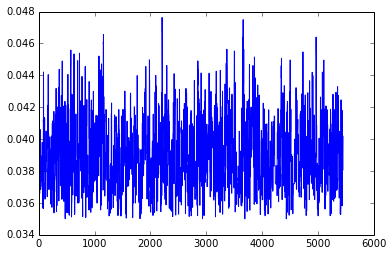

In [201]:
plt.plot(samples[:i])
print np.sum(acceptances[:i]) * 1./ i
print np.mean(samples[:i])

### Some observations here

The problems with this are pretty numerous, and it's difficult to pin down exactly what could be the issue.

So the first, most obvious thing is the size of the p_pn estimates. They *seem* pretty ridiculous - like, they should be much smaller than they are. What are they saying? Effectively they're saying that delta lies in an *enormous* peak of probability, so there is a delta-function like probability sitting at the value of delta we've found. And once we enter that peak we can't ever leave it, because the gradient is too steep and all the other possible values are just spectacularly less likely.

Now I've looked through this code several times and I can't *see* any problem with it. The part which seems to be giving such absurdly high values is the actual p_pn estimate itself, so the estimate of $r$ is probably okay. So what *is* p_pn? It's a Gaussian distribution which is based on the distance from my collocation approximation - i.e. a Gaussian likelihood based on the collocation approximation for $u$. And so what we're saying when we have that just so large is that *that* likelihood is a delta function. i.e. that the only value which is in any way likely is the true solution.

In [182]:
delta = 0.039
next = 0.0391
solutions = find_solutions(next, 50, cur_solutions)
for i in range(50):
    print np.mean(np.exp(log_p_pn_estimate(true_obs, next, solutions, likelihood_variance, z_proposal_variance, 50)))

6.58361185563e+32
1.82937615678e+34
6.57686427399e+29
8.5001187461e+21
1.29596155011e+30
2.54675222055e+33
6.66228957473e+28
6.65783577603e+37


KeyboardInterrupt: 

In [181]:

for i in range(50):
    print np.exp(np.mean(log_p_pn_estimate(true_obs, next, solutions, likelihood_variance, z_proposal_variance, 50)))

0.0
0.0
0.0
0.0
0.0


KeyboardInterrupt: 

In [154]:
likelihood_variance

0.1

In [155]:
log_p_pn_estimate(true_obs, next, solutions, 0.01, z_proposal_variance, 500, debug=True)

Iteration 0, mixture 1
Log-PN Proba: -2654.06280832 Log-r: -5.98353725529 Log-Estimate: -2648.07927107
Iteration 1, mixture 2
Log-PN Proba: -475992.973026 Log-r: -4.81945951253 Log-Estimate: -475988.153567
Iteration 2, mixture 0
Log-PN Proba: -471500.554513 Log-r: -16.8384859315 Log-Estimate: -471483.716027
Iteration 3, mixture 0
Log-PN Proba: -476854.937515 Log-r: -5.62427884913 Log-Estimate: -476849.313236
Iteration 4, mixture 2
Log-PN Proba: -467963.119456 Log-r: -0.884809159877 Log-Estimate: -467962.234647
Iteration 5, mixture 1
Log-PN Proba: -3156.92524406 Log-r: -6.63406054266 Log-Estimate: -3150.29118352
Iteration 6, mixture 2
Log-PN Proba: -474003.791426 Log-r: -3.61689390285 Log-Estimate: -474000.174532
Iteration 7, mixture 1
Log-PN Proba: -2534.4138997 Log-r: 3.24332974156 Log-Estimate: -2537.65722944
Iteration 8, mixture 0
Log-PN Proba: -477391.105532 Log-r: 2.41991937623 Log-Estimate: -477393.525451
Iteration 9, mixture 2
Log-PN Proba: -465796.198027 Log-r: -3.14034389969 L

KeyboardInterrupt: 